# 1. Setting up Environments, Loading Preprocessed Data and Splitting into Train/Test

In this section, we import require libraries, load our pre-processed data and manage versioning issues. mT5 benefits from stripping English translations of non-letter characters which is what L1_clean refers to. Lastly, we segment data into Train/Test/Val.

In [4]:
# ============================================================
# 1. Setting up Environments, Loading Preprocessed Data and Splitting into Train/Test
# ============================================================

!pip uninstall -y wandb -q
!pip install -U -q "transformers>=4.38.0" "datasets>=2.18.0" accelerate sacrebleu evaluate sentencepiece

import os
import re
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from transformers import (
    MT5ForConditionalGeneration,
    T5Tokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)
import evaluate

# -------------------------------------------------------------------
# 0. Environment / sanity
# -------------------------------------------------------------------
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

print("Torch version:", torch.__version__)
import transformers
print("Transformers version:", transformers.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# -------------------------------------------------------------------
# 0b. Arabic normalization helper
# -------------------------------------------------------------------
def norm_ar(s):
    if not isinstance(s, str):
        s = str(s)
    # strip diacritics and tatweel
    s = re.sub(r"[\u064B-\u0652\u0670\u0640]", "", s)
    # normalize alef / ya / ta marbuta
    s = s.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")
    s = s.replace("ى", "ي").replace("ة", "ه")
    return s

# -------------------------------------------------------------------
# 1. Load data from Drive
# -------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/My Drive/ISchool/MIDS/266/processed_data"

verse_path       = os.path.join(output_dir, "verse_df_final.parquet")
words_path       = os.path.join(output_dir, "words_df.parquet")
expression_path  = os.path.join(output_dir, "expression_df.parquet")

loaded_verse_df_final = pd.read_parquet(verse_path)
loaded_words_df       = pd.read_parquet(words_path)
loaded_expression_df  = pd.read_parquet(expression_path)

# -------------------------------------------------------------------
# 1b. Apply Arabic normalization to all Arabic text columns <in naveeds notebook this is done pre-processing, in mine it is done here due to a timing issue>
# -------------------------------------------------------------------
# Verses
loaded_verse_df_final["verse_norm"] = loaded_verse_df_final["verse"].apply(norm_ar)

# Word-level tokens
if "Token" in loaded_words_df.columns:
    loaded_words_df["Token_norm"] = loaded_words_df["Token"].apply(norm_ar)

# Expression-level tokens
if "Token" in loaded_expression_df.columns:
    loaded_expression_df["Token_norm"] = loaded_expression_df["Token"].apply(norm_ar)

print("verse_df_final (with normalized verse_norm):")
display(loaded_verse_df_final.head())

print("words_df (with Token_norm):")
display(loaded_words_df.head())

print("expression_df (with Token_norm):")
display(loaded_expression_df.head())

# -------------------------------------------------------------------
# 2. Build verse pairs + clean labels (L1_clean)
# -------------------------------------------------------------------

# Use normalized verse + English translation
verse_pairs_df_all = loaded_verse_df_final[["verse_norm", "L1"]].copy()
verse_pairs_df_all = verse_pairs_df_all.rename(columns={"verse_norm": "verse"})

def strip_html(text: str) -> str:
    return re.sub(r"<.*?>", "", str(text))

# Cleaned English translations
verse_pairs_df_all["L1_clean"] = verse_pairs_df_all["L1"].apply(strip_html)

# Drop NaNs & empty strings
verse_pairs_df = verse_pairs_df_all.dropna(subset=["verse", "L1_clean"]).copy()

verse_pairs_df = verse_pairs_df[
    verse_pairs_df["verse"].astype(str).str.strip() != ""
]
verse_pairs_df = verse_pairs_df[
    verse_pairs_df["L1_clean"].astype(str).str.strip() != ""
]

# Shuffle
verse_pairs_df = verse_pairs_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Total verse pairs after cleaning:", len(verse_pairs_df))
display(verse_pairs_df.head())

# Keeping a copy of original (for later qualitative inspection)
verse_pairs_df_all = verse_pairs_df[["verse", "L1", "L1_clean"]].copy()

# -------------------------------------------------------------------
# 3. Train/val/test split & HF Datasets
# -------------------------------------------------------------------
train_df, temp_df = train_test_split(verse_pairs_df, test_size=0.2, random_state=42)
val_df,   test_df = train_test_split(temp_df,       test_size=0.5, random_state=42)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))

# We only need verse + L1_clean in the HF datasets
train_ds = Dataset.from_pandas(train_df[["verse", "L1_clean"]].reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df[["verse", "L1_clean"]].reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df[["verse", "L1_clean"]].reset_index(drop=True))

raw_datasets = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

raw_datasets


Torch version: 2.9.0+cu126
Transformers version: 4.57.3
Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Mounted at /content/drive
verse_df_final (with normalized verse_norm):


,TokenPOS,L1,verse,verse_norm
0,1:1,"In the name of Allah, the Gracious, the Merciful.",بِسْمِ ٱللَّهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ,بسم ٱلله ٱلرحمن ٱلرحيم
1,1:2,"All praise belongs to Allah, Lord of all the w...",ٱلْحَمْدُ لِلَّهِ رَبِّ ٱلْعَٰلَمِينَ,ٱلحمد لله رب ٱلعلمين
2,1:3,"The Gracious, the Merciful,",ٱلرَّحْمَٰنِ ٱلرَّحِيمِ,ٱلرحمن ٱلرحيم
3,1:4,Master of the Day of Judgment.,مَٰلِكِ يَوْمِ ٱلدِّينِ,ملك يوم ٱلدين
4,1:5,Thee alone do we worship and Thee alone do we ...,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,اياك نعبد واياك نستعين


words_df (with Token_norm):


,Token,L4_Embedding,L2_WordbyWord,Token_norm
0,بِسْمِ,"With the name,I begin by calling",In the name of,بسم
1,ٱللَّهِ,,Allah,ٱلله
2,ٱلرَّحْمَٰنِ,"the Most Compassionate,the Entirely Merciful,t...",the Gracious,ٱلرحمن
3,ٱلرَّحِيمِ,"the Most Merciful,the Bestower of mercy,the Es...",the Merciful,ٱلرحيم
4,ٱلْحَمْدُ,"Praise,Praise be,All the praises and thanks",All praise,ٱلحمد


expression_df (with Token_norm):


,Token,L2Expression,L4_Embedding,Token_norm
0,إِذَا بُعْثِرَ مَا,that when those in the graves are raised,,اذا بعثر ما
1,فِى ٱلْقُبُورِ,those in the graves are raised,,في ٱلقبور
2,وَحُصِّلَ مَا فِى ٱلصُّدُورِ,And that which is in the breasts is brought forth,"And is made apparent,what",وحصل ما في ٱلصدور
3,وَٱلْعَٰدِيَٰتِ ضَبْحًا,By the snorting chargers <I>of the warriors</I>,"By the racers,panting",وٱلعديت ضبحا
4,فَٱلْمُورِيَٰتِ قَدْحًا,Striking sparks of fire,"And the producers of sparks,then striking spar...",فٱلموريت قدحا


Total verse pairs after cleaning: 5543


,verse,L1,L1_clean
0,انآ اعتدنا للكفرين سلسلا۟ واغللا وسعيرا,"Verily, We have prepared for the disbelievers ...","Verily, We have prepared for the disbelievers ..."
1,زين للذين كفروا۟ ٱلحيوه ٱلدنيا ويسخرون من ٱلذي...,The life of this world is made <i>to appear</i...,The life of this world is made to appear attra...
2,اذا ٱلسمآء ٱنشقت,"When the heaven bursts asunder,","When the heaven bursts asunder,"
3,وجآء ٱلمعذرون من ٱلاعراب ليؤذن لهم وقعد ٱلذين...,And those who make excuses from among the dese...,And those who make excuses from among the dese...
4,امن يهديكم في ظلمت ٱلبر وٱلبحر ومن يرسل ٱلريح ...,"Or, Who guides you in every <I>kind of </I>dar...","Or, Who guides you in every kind of darkness o..."


Train size: 4434
Val size:   554
Test size:  555


DatasetDict({
    train: Dataset({
        features: ['verse', 'L1_clean'],
        num_rows: 4434
    })
    validation: Dataset({
        features: ['verse', 'L1_clean'],
        num_rows: 554
    })
    test: Dataset({
        features: ['verse', 'L1_clean'],
        num_rows: 555
    })
})

# 2. Building the Tokenizer, Model and Eval metrics

Initial mT5 testing was returning 0 BLEU scores and <extra id> outputs. To test that the pipes were actually working, I tested using a tiny subset of the data and corrected initial ingestion + safer eval accordingly. This testing was done in a draft notebook. In this section, I load the mt5 model and tokenize and call the required eval metrics before moving onto fine tuning. Note, it is important to define a preprocess function that gives the mt5 the specific translation "task".

In [5]:
# -------------------------------------------------------------------
# 4. Tokenizer + model
# -------------------------------------------------------------------
model_name = "google/mt5-small"

tokenizer = T5Tokenizer.from_pretrained(model_name)
model = MT5ForConditionalGeneration.from_pretrained(model_name).to(device)

max_source_length = 128
max_target_length = 128

# Translation-style prefix
def preprocess_function(examples):
    # Source: Arabic verse with prefix
    inputs = [
        "translate Quranic Arabic to English: " + verse
        for verse in examples["verse"]
    ]

    model_inputs = tokenizer(
        inputs,
        max_length=max_source_length,
        truncation=True,
    )

    # Target: cleaned English translation
    labels = tokenizer(
        text_target=examples["L1_clean"],
        max_length=max_target_length,
        truncation=True,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,  # removes verse + L1_clean
)

tokenized_datasets

# -------------------------------------------------------------------
# 4b. Manual batch loss sanity check (fresh model) [All this is doing is force checking the pipes work]
# -------------------------------------------------------------------
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

debug_loader = DataLoader(
    tokenized_datasets["train"],
    batch_size=4,
    shuffle=False,
    collate_fn=data_collator,
)

batch = next(iter(debug_loader))
batch = {k: v.to(device) for k, v in batch.items()}

model.eval()
with torch.no_grad():
    outputs = model(**batch)
    print("Manual batch loss (fresh model):", outputs.loss.item())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/4434 [00:00<?, ? examples/s]

Map:   0%|          | 0/554 [00:00<?, ? examples/s]

Map:   0%|          | 0/555 [00:00<?, ? examples/s]

Manual batch loss (fresh model): 34.641143798828125


In [6]:
# -------------------------------------------------------------------
# 5. Optionally restrict dataset sizes (setting None for full)
# -------------------------------------------------------------------
max_train_samples = None    # e.g. 2000 for quick dev
max_val_samples   = None    # e.g. 400

if max_train_samples is not None:
    train_dataset = tokenized_datasets["train"].select(
        range(min(max_train_samples, len(tokenized_datasets["train"])))
    )
else:
    train_dataset = tokenized_datasets["train"]

if max_val_samples is not None:
    val_dataset = tokenized_datasets["validation"].select(
        range(min(max_val_samples, len(tokenized_datasets["validation"])))
    )
else:
    val_dataset = tokenized_datasets["validation"]

print("Train used:", len(train_dataset))
print("Val used:  ", len(val_dataset))

sample = train_dataset[0]
print("Sample labels (first 30 ids):", sample["labels"][:30])

# -------------------------------------------------------------------
# 6. Metrics: BLEU, BLEURT, exact-match accuracy [which would mean 1:1 translation matching]
# -------------------------------------------------------------------
!pip install -q git+https://github.com/google-research/bleurt.git # Install bleurt
bleu_metric   = evaluate.load("sacrebleu")
bleurt_metric = evaluate.load("bleurt", "bleurt-20")

vocab_size = tokenizer.vocab_size
max_bleurt_eval = 512

def postprocess_text(preds, labels):
    preds  = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # 1) Solid labels (-100 -> pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # 2) Clip predictions to [0, vocab_size-1] to avoid sentencepiece IndexError
    pred_min, pred_max = predictions.min(), predictions.max()
    if pred_min < 0 or pred_max >= vocab_size:
        print(f"⚠️ Clipping predictions: min={pred_min}, max={pred_max}, vocab_size={vocab_size}")
        predictions = np.clip(predictions, 0, vocab_size - 1)

    # Also clip labels for safety
    lab_min, lab_max = labels.min(), labels.max()
    if lab_min < 0 or lab_max >= vocab_size:
        print(f"⚠️ Clipping labels: min={lab_min}, max={lab_max}, vocab_size={vocab_size}")
        labels = np.clip(labels, 0, vocab_size - 1)

    # 3) Decode
    decoded_preds  = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels,     skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    print("metrics: n_preds / n_labels =", len(decoded_preds), len(decoded_labels))
    print("metrics sample preds:", decoded_preds[:3])
    print("metrics sample labels:", decoded_labels[:3])

    if len(decoded_preds) == 0:
        return {"bleu": 0.0, "bleurt": 0.0, "accuracy": 0.0}

    # 4) BLEU
    bleu = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[l] for l in decoded_labels],
    )["score"]

    # 5) BLEURT
    if max_bleurt_eval is not None and len(decoded_preds) > max_bleurt_eval:
        bleurt_preds  = decoded_preds[:max_bleurt_eval]
        bleurt_labels = decoded_labels[:max_bleurt_eval]
    else:
        bleurt_preds  = decoded_preds
        bleurt_labels = decoded_labels

    bleurt_scores = bleurt_metric.compute(
        predictions=bleurt_preds,
        references=bleurt_labels,
    )["scores"]
    bleurt_mean = float(np.mean(bleurt_scores))

    # 6) Sequence-level exact match (will be ~0; that’s expected)
    accuracy = float(np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)]))

    return {
        "bleu": bleu,
        "bleurt": bleurt_mean,
        "accuracy": accuracy,
    }

Train used: 4434
Val used:   554
Sample labels (first 30 ids): [1916, 533, 339, 351, 609, 274, 102986, 271, 898, 4747, 8125, 260, 1]
  Preparing metadata (setup.py) ... done


Computing checksums: 100%|##########| 1/1 [00:06<00:00,  6.08s/it]

# 3. Building Safe(r) Trainer and Running Model

The most important piece in this section is the Safer Seq2Seq trainer, which essentially strips out nan values and ultimately guards against NaN values downstream.

In [7]:
# -------------------------------------------------------------------
# 7. Safe Trainer to avoid NaN/Inf losses
# -------------------------------------------------------------------
class SafeSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Standard forward pass
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            labels=inputs.get("labels"),
        )
        loss = outputs.loss

        # Guard against NaN/Inf
        if torch.isnan(loss) or torch.isinf(loss):
            print("NaN/Inf loss encountered, skipping this batch.")
            loss = torch.zeros((), device=loss.device)

        return (loss, outputs) if return_outputs else loss

# -------------------------------------------------------------------
# 8. Training arguments (full) [in draft notebooks, I tried a small sample to ensure pipes were actually working]
# -------------------------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_full",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="bleurt",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

trainer = SafeSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
print(train_result)

val_metrics = trainer.evaluate(eval_dataset=val_dataset)
print("Validation metrics:", val_metrics)


/tmp/ipython-input-1880009309.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = SafeSeq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Bleu,Bleurt,Accuracy
1,5.090100,3.856164,0.181202,0.262769,0.000000
2,4.314700,3.484150,0.495208,0.304283,0.000000
3,4.091600,3.348732,0.647298,0.303346,0.000000
4,3.983800,3.284259,0.760922,0.291751,0.000000
5,3.990500,3.262341,0.997833,0.298629,0.000000


⚠️ Clipping predictions: min=-100, max=250099, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['<extra_id_0>, and they are a truth.', '<extra_id_0>, and they are a certain truth.', '<extra_id_0>, and they are a very evil.']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
⚠️ Clipping predictions: min=-100, max=173123, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And they shall be a reward for the reward.', 'And they will be a certain manner.', 'And they shall become a reward.']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
⚠️ Clipping 

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=5545, training_loss=5.30844627222142, metrics={'train_runtime': 880.0882, 'train_samples_per_second': 25.191, 'train_steps_per_second': 6.301, 'total_flos': 1415989606748160.0, 'train_loss': 5.30844627222142, 'epoch': 5.0})


⚠️ Clipping predictions: min=-100, max=173123, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And they shall be a reward for the reward.', 'And they will be a certain manner.', 'And they shall become a reward.']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
Validation metrics: {'eval_loss': 3.4841501712799072, 'eval_bleu': 0.49520776290043844, 'eval_bleurt': 0.3042832296923734, 'eval_accuracy': 0.0, 'eval_runtime': 57.5328, 'eval_samples_per_second': 9.629, 'eval_steps_per_second': 2.416, 'epoch': 5.0}


# 4. Adding Word Level And Expression Level Pretraining

In this section, I pretrain the model on word level + expression level data from the SherAli corpus before moving on to verse level fine tuning. The hypothesis is that results should improve because we are pretraining the model with more granular data. However, we still don't expect massive improvements in absolute terms, but are rather looking for a relative improvement proportional to the dataset and the baseline we're starting with.

In [8]:
# ============================================================
# 4. Multi-level training: word -> expression -> verse (new model)
# ============================================================

print("Words DF columns:", loaded_words_df.columns)
print("Expression DF columns:", loaded_expression_df.columns)

# ------------------------------------------------------------
# 4.1 Configure column names for word- and expression-level data
# ------------------------------------------------------------


WORD_AR_COL = "Token"          # Arabic word (will come from Token_norm)
WORD_EN_COL = "L2_WordbyWord"

EXPR_AR_COL = "Token"          # Arabic phrase/expression (from Token_norm)
EXPR_EN_COL = "L2Expression"

# Stripping punctuation in English
def strip_non_letters(text: str) -> str:
    return re.sub(r"[^A-Za-z\s]", " ", str(text))

def take_first_variant(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    first = text.split(",")[0]
    return first.strip()

# ------------------------------------------------------------
# 4.2 Build cleaned word-level and expression-level dataframes
#     (using normalized Arabic from Token_norm)
# ------------------------------------------------------------

# ---- WORD LEVEL ----
# Use normalized Arabic: Token_norm -> WORD_AR_COL ("Token")
word_pairs_df = loaded_words_df[["Token_norm", WORD_EN_COL]].dropna().copy()
word_pairs_df.rename(columns={"Token_norm": WORD_AR_COL}, inplace=True)

word_pairs_df[WORD_AR_COL] = word_pairs_df[WORD_AR_COL].astype(str).str.strip()
word_pairs_df[WORD_EN_COL] = word_pairs_df[WORD_EN_COL].astype(str).str.strip()

# Drop empties
word_pairs_df = word_pairs_df[
    (word_pairs_df[WORD_AR_COL] != "") & (word_pairs_df[WORD_EN_COL] != "")
].reset_index(drop=True)

# Clean English
word_pairs_df["EN_clean"] = (
    word_pairs_df[WORD_EN_COL]
    .apply(take_first_variant)
    .apply(strip_non_letters)
)

print("Word-level pairs:", len(word_pairs_df))
display(word_pairs_df.head())

# ---- EXPRESSION LEVEL ----
# Use normalized Arabic: Token_norm -> EXPR_AR_COL ("Token")
expr_pairs_df = loaded_expression_df[["Token_norm", EXPR_EN_COL]].dropna().copy()
expr_pairs_df.rename(columns={"Token_norm": EXPR_AR_COL}, inplace=True)

expr_pairs_df[EXPR_AR_COL] = expr_pairs_df[EXPR_AR_COL].astype(str).str.strip()
expr_pairs_df[EXPR_EN_COL] = expr_pairs_df[EXPR_EN_COL].astype(str).str.strip()

expr_pairs_df = expr_pairs_df[
    (expr_pairs_df[EXPR_AR_COL] != "") & (expr_pairs_df[EXPR_EN_COL] != "")
].reset_index(drop=True)

expr_pairs_df["EN_clean"] = (
    expr_pairs_df[EXPR_EN_COL]
    .apply(take_first_variant)
    .apply(strip_non_letters)
)

print("Expression-level pairs:", len(expr_pairs_df))
display(expr_pairs_df.head())

# ------------------------------------------------------------
# 4.3 HuggingFace Datasets for word- and expression-level
# ------------------------------------------------------------
from datasets import Dataset

word_ds = Dataset.from_pandas(
    word_pairs_df[[WORD_AR_COL, "EN_clean"]].rename(
        columns={WORD_AR_COL: "ar", "EN_clean": "en"}
    )
)

expr_ds = Dataset.from_pandas(
    expr_pairs_df[[EXPR_AR_COL, "EN_clean"]].rename(
        columns={EXPR_AR_COL: "ar", "EN_clean": "en"}
    )
)

print("Word HF dataset:", word_ds)
print("Expr HF dataset:", expr_ds)

# ------------------------------------------------------------
# 4.4 Preprocessing functions for each level
# ------------------------------------------------------------
max_source_length = 128
max_target_length_word = 32    # shorter for words
max_target_length_expr = 64    # phrases

def preprocess_word(examples):
    # Task prefix: word-level
    inputs = [
        "translate Arabic word to English: " + x
        for x in examples["ar"]   # already normalized upstream
    ]
    model_inputs = tokenizer(
        inputs,
        max_length=max_source_length,
        truncation=True,
    )

    labels = tokenizer(
        text_target=examples["en"],
        max_length=max_target_length_word,
        truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

def preprocess_expr(examples):
    # Task prefix: phrase-level
    inputs = [
        "translate Arabic phrase to English: " + x
        for x in examples["ar"]   # already normalized upstream
    ]
    model_inputs = tokenizer(
        inputs,
        max_length=max_source_length,
        truncation=True,
    )

    labels = tokenizer(
        text_target=examples["en"],
        max_length=max_target_length_expr,
        truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize word- and expression-level datasets
word_tokenized = word_ds.map(
    preprocess_word,
    batched=True,
    remove_columns=word_ds.column_names,
)

expr_tokenized = expr_ds.map(
    preprocess_expr,
    batched=True,
    remove_columns=expr_ds.column_names,
)

print("Word tokenized:", word_tokenized)
print("Expr tokenized:", expr_tokenized)

max_word_samples = None
max_expr_samples = None

if max_word_samples is not None:
    word_train_ds = word_tokenized.select(range(min(max_word_samples, len(word_tokenized))))
else:
    word_train_ds = word_tokenized

if max_expr_samples is not None:
    expr_train_ds = expr_tokenized.select(range(min(max_expr_samples, len(expr_tokenized))))
else:
    expr_train_ds = expr_tokenized

print("Word train size:", len(word_train_ds))
print("Expr train size:", len(expr_train_ds))

# ------------------------------------------------------------
# 4.5 New model instance for multi-stage training (word -> expr -> verse)
# ------------------------------------------------------------
from transformers import MT5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments

model_wp = MT5ForConditionalGeneration.from_pretrained("google/mt5-small").to(device)
data_collator_wp = DataCollatorForSeq2Seq(tokenizer, model=model_wp)

# We reuse SafeSeq2SeqTrainer and compute_metrics from above

# ------------------------------------------------------------
# 4.6 Stage A: Train on word-level
# ------------------------------------------------------------
word_training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_word_stage",
    overwrite_output_dir=True,
    eval_strategy="no",       # we dont need metrics at each stage
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=False,
    fp16=False,
    learning_rate=5e-5,
    num_train_epochs=2,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=200,
    report_to="none",
)

trainer_word = SafeSeq2SeqTrainer(
    model=model_wp,
    args=word_training_args,
    train_dataset=word_train_ds,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator_wp,
    compute_metrics=None,
)

print(">>> Stage A: Training on word-level data")
word_train_result = trainer_word.train()
print(word_train_result)

# ------------------------------------------------------------
# 4.7 Stage B: Train on expression-level
# ------------------------------------------------------------
expr_training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_expr_stage",
    overwrite_output_dir=True,
    eval_strategy="no",
    save_strategy="no",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=False,
    fp16=False,
    learning_rate=3e-5,
    num_train_epochs=2,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=200,
    report_to="none",
)

trainer_expr = SafeSeq2SeqTrainer(
    model=model_wp,
    args=expr_training_args,
    train_dataset=expr_train_ds,
    eval_dataset=None,
    tokenizer=tokenizer,
    data_collator=data_collator_wp,
    compute_metrics=None,
)

print(">>> Stage B: Training on expression-level data")
expr_train_result = trainer_expr.train()
print(expr_train_result)

# ------------------------------------------------------------
# 4.8 Stage C: Verse-level fine-tuning (same verse data as baseline)
# ------------------------------------------------------------
verse_training_args_wp = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_verse_stage_wp",
    overwrite_output_dir=True,
    eval_strategy="epoch",  # we DO want metrics here
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="bleurt",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

trainer_verse_wp = SafeSeq2SeqTrainer(
    model=model_wp,
    args=verse_training_args_wp,
    train_dataset=train_dataset,   # built from normalized verses in Section 1
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator_wp,
    compute_metrics=compute_metrics,
)

print(">>> Stage C: Verse-level fine-tuning (word+expr+verse model)")
verse_train_result_wp = trainer_verse_wp.train()
print(verse_train_result_wp)

val_metrics_wp = trainer_verse_wp.evaluate(eval_dataset=val_dataset)
print("Multi-stage (word+expr+verse) validation metrics:", val_metrics_wp)

# ------------------------------------------------------------
# 4.9 Save multi-stage model and define comparison helpers
# ------------------------------------------------------------
save_path_wp = "/content/drive/My Drive/ISchool/MIDS/266/mt5_quran_word_expr_verse"
os.makedirs(save_path_wp, exist_ok=True)
trainer_verse_wp.save_model(save_path_wp)
tokenizer.save_pretrained(save_path_wp)

print("Saved multi-stage model (word+expr+verse) to:", save_path_wp)
print("Files:", os.listdir(save_path_wp))

# Baseline (verse-only) model is still in `model`
def translate_verse_baseline(ar_text, max_new_tokens=64):
    # optional: norm_ar(ar_text) here if you pass raw Quranic text
    prefixed = "translate Quranic Arabic to English: " + ar_text
    inputs = tokenizer(prefixed, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
        )
    return tokenizer.decode(gen_ids[0], skip_special_tokens=True)

# Multi-stage model (word+expr+verse)
def translate_verse_multi(ar_text, max_new_tokens=64):
    # optional: norm_ar(ar_text) here too
    prefixed = "translate Quranic Arabic to English: " + ar_text
    inputs = tokenizer(prefixed, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        gen_ids = model_wp.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
        )
    return tokenizer.decode(gen_ids[0], skip_special_tokens=True)

# Comparison on select verses
for i in range(5):
    ar  = verse_pairs_df_all.loc[i, "verse"]      # already normalized in Section 1
    ref = verse_pairs_df_all.loc[i, "L1_clean"]
    base_pred  = translate_verse_baseline(ar)
    multi_pred = translate_verse_multi(ar)

    print(f"Verse {i+1}")
    print("AR:           ", ar)
    print("REF:          ", ref)
    print("BASE (verse): ", base_pred)
    print("MULTI (W+E+V):", multi_pred)
    print("-" * 120)


Words DF columns: Index(['Token', 'L4_Embedding', 'L2_WordbyWord', 'Token_norm'], dtype='object')
Expression DF columns: Index(['Token', 'L2Expression', 'L4_Embedding', 'Token_norm'], dtype='object')
Word-level pairs: 54473


,Token,L2_WordbyWord,EN_clean
0,بسم,In the name of,In the name of
1,ٱلله,Allah,Allah
2,ٱلرحمن,the Gracious,the Gracious
3,ٱلرحيم,the Merciful,the Merciful
4,ٱلحمد,All praise,All praise


Expression-level pairs: 4711


,Token,L2Expression,EN_clean
0,اذا بعثر ما,that when those in the graves are raised,that when those in the graves are raised
1,في ٱلقبور,those in the graves are raised,those in the graves are raised
2,وحصل ما في ٱلصدور,And that which is in the breasts is brought forth,And that which is in the breasts is brought forth
3,وٱلعديت ضبحا,By the snorting chargers <I>of the warriors</I>,By the snorting chargers I of the warriors I
4,فٱلموريت قدحا,Striking sparks of fire,Striking sparks of fire


Word HF dataset: Dataset({
    features: ['ar', 'en'],
    num_rows: 54473
})
Expr HF dataset: Dataset({
    features: ['ar', 'en'],
    num_rows: 4711
})


Map:   0%|          | 0/54473 [00:00<?, ? examples/s]

Map:   0%|          | 0/4711 [00:00<?, ? examples/s]

Word tokenized: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 54473
})
Expr tokenized: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 4711
})
Word train size: 54473
Expr train size: 4711


/tmp/ipython-input-926257650.py:208: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_word = SafeSeq2SeqTrainer(


>>> Stage A: Training on word-level data


Step,Training Loss
200,19.556400
400,10.556600
600,6.758800
800,5.382300
1000,4.904600
1200,4.588800
1400,4.459200
1600,4.345200
1800,4.241500
2000,4.143600


TrainOutput(global_step=6810, training_loss=4.6358835223137715, metrics={'train_runtime': 667.4189, 'train_samples_per_second': 163.235, 'train_steps_per_second': 10.203, 'total_flos': 1434069334947840.0, 'train_loss': 4.6358835223137715, 'epoch': 2.0})
>>> Stage B: Training on expression-level data


/tmp/ipython-input-926257650.py:243: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_expr = SafeSeq2SeqTrainer(


Step,Training Loss
200,3.451300
400,3.416300
600,3.430900
800,3.353000
1000,3.318300


TrainOutput(global_step=1178, training_loss=3.3798244715951293, metrics={'train_runtime': 113.7035, 'train_samples_per_second': 82.865, 'train_steps_per_second': 10.36, 'total_flos': 174564851558400.0, 'train_loss': 3.3798244715951293, 'epoch': 2.0})
>>> Stage C: Verse-level fine-tuning (word+expr+verse model)


/tmp/ipython-input-926257650.py:283: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_verse_wp = SafeSeq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Bleu,Bleurt,Accuracy
1,3.725800,3.104318,0.908536,0.324932,0.000000
2,3.557100,2.959191,1.329880,0.324088,0.000000
3,3.469200,2.883472,1.491427,0.332835,0.000000
4,3.401000,2.840961,1.680596,0.324330,0.000000
5,3.414600,2.827744,1.779391,0.331787,0.000000


⚠️ Clipping predictions: min=-100, max=184873, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And he said, ‘They will not believe in it.’', 'And the truth is the truth of the earth.', 'And he took him from the mountains and the mountains and the mountains and the']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
⚠️ Clipping predictions: min=-100, max=184873, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And said, ‘We have already gone in it, and believe not in it.', 'And the truth is the truth of the earth.', 'And He took him from the mountains and the mountains, and he took him from']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his 

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=5545, training_loss=3.576402317112475, metrics={'train_runtime': 890.0672, 'train_samples_per_second': 24.908, 'train_steps_per_second': 6.23, 'total_flos': 1415989606748160.0, 'train_loss': 3.576402317112475, 'epoch': 5.0})


⚠️ Clipping predictions: min=-100, max=184873, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And said, ‘We have destroyed it in the heavens and shall not be', 'And the truth is the truth.', 'And He took him from the mountains and the mountains, and he said, ‘O']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
Multi-stage (word+expr+verse) validation metrics: {'eval_loss': 2.883471965789795, 'eval_bleu': 1.4914272649268514, 'eval_bleurt': 0.3328353117685765, 'eval_accuracy': 0.0, 'eval_runtime': 57.7687, 'eval_samples_per_second': 9.59, 'eval_steps_per_second': 2.406, 'epoch': 5.0}
Saved multi-stage model (word+expr+verse) to: /content/drive/My Drive/ISchool/MIDS/266/mt5_quran_word_expr_verse
Files: ['config.json', 'generation_config.json', 'model.safetensors',

# 5. Adding an Additional Dataset

After significant compute challenges trying to use the MaLa dataset, I went with the Flores+ corpus which issues non classical English > Arabic. In the below section, I load and ready the data and then run pretrain the mt5 model with the additional source. I then performe the same verse level fine tuning and run a comparison between the models from Section 4 and this new Flores+ added model.

In [11]:
# ============================================================
# 5. External FLORES+ pretraining + Qur'an verse fine-tuning
# ============================================================
# Note AI assistance was required for below section since I was having issues loading a "ready to use" corpus

import os
import shutil
from datasets import load_dataset

# ------------------------------------------------------------
# 5.1 Load FLORES+ Arabic–English (MSA) from Hugging Face
# ------------------------------------------------------------
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets/openlanguagedata___flores_plus/")
if os.path.exists(cache_dir):
    print(f"Removing existing cache directory: {cache_dir}")
    shutil.rmtree(cache_dir)

arb_dev = load_dataset(
    "openlanguagedata/flores_plus",
    "arb_Arab",
    split="dev",
    download_mode="force_redownload",
)

eng_dev = load_dataset(
    "openlanguagedata/flores_plus",
    "eng_Latn",
    split="dev",
    download_mode="force_redownload",
)

arb_devtest = load_dataset(
    "openlanguagedata/flores_plus",
    "arb_Arab",
    split="devtest",
    download_mode="force_redownload",
)

eng_devtest = load_dataset(
    "openlanguagedata/flores_plus",
    "eng_Latn",
    split="devtest",
    download_mode="force_redownload",
)

print("arb_dev:", arb_dev)
print("eng_dev:", eng_dev)
print("arb_devtest:", arb_devtest)
print("eng_devtest:", eng_devtest)

# ------------------------------------------------------------
# 5.2 Build simple (ar, en) pairs from FLORES+
# ------------------------------------------------------------

eng_dev_lookup = {ex["id"]: ex["text"] for ex in eng_dev}
eng_devtest_lookup = {ex["id"]: ex["text"] for ex in eng_devtest}

def make_flores_pairs(examples, eng_lookup):
    ids = examples["id"]
    ar_sentences = examples["text"]
    en_sentences = [eng_lookup[_id] for _id in ids]

    return {
        "ar": ar_sentences,
        "en": en_sentences,
    }

flores_train_pairs = arb_dev.map(
    make_flores_pairs,
    batched=True,
    fn_kwargs={"eng_lookup": eng_dev_lookup},
    remove_columns=arb_dev.column_names,  # drop original columns, keep only ar/en
)

flores_val_pairs = arb_devtest.map(
    make_flores_pairs,
    batched=True,
    fn_kwargs={"eng_lookup": eng_devtest_lookup},
    remove_columns=arb_devtest.column_names,
)

print(flores_train_pairs[0])
print(flores_val_pairs[0])

# ------------------------------------------------------------
# 5.3 Tokenize FLORES+ for MT5 (Arabic -> English) WITH NORMALIZATION
# ------------------------------------------------------------
max_source_length_flores = 128
max_target_length_flores = 128

def preprocess_flores(examples):
    # 🔹 Normalize Arabic before giving it to the model
    ar_norm = [norm_ar(x) for x in examples["ar"]]

    inputs = [
        "translate Arabic to English: " + x
        for x in ar_norm
    ]
    model_inputs = tokenizer(
        inputs,
        max_length=max_source_length_flores,
        truncation=True,
    )

    labels = tokenizer(
        text_target=examples["en"],
        max_length=max_target_length_flores,
        truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

flores_train_tok = flores_train_pairs.map(
    preprocess_flores,
    batched=True,
    remove_columns=flores_train_pairs.column_names,
)

flores_val_tok = flores_val_pairs.map(
    preprocess_flores,
    batched=True,
    remove_columns=flores_val_pairs.column_names,
)

print("FLORES+ tokenized train:", flores_train_tok)
print("FLORES+ tokenized val:  ", flores_val_tok)


Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

dev/arb_Arab.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

devtest/arb_Arab.parquet:   0%|          | 0.00/143k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/997 [00:00<?, ? examples/s]

Generating devtest split:   0%|          | 0/1012 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

dev/eng_Latn.parquet:   0%|          | 0.00/112k [00:00<?, ?B/s]

devtest/eng_Latn.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/997 [00:00<?, ? examples/s]

Generating devtest split:   0%|          | 0/1012 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

dev/arb_Arab.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

devtest/arb_Arab.parquet:   0%|          | 0.00/143k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/997 [00:00<?, ? examples/s]

Generating devtest split:   0%|          | 0/1012 [00:00<?, ? examples/s]

Resolving data files:   0%|          | 0/224 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

dev/eng_Latn.parquet:   0%|          | 0.00/112k [00:00<?, ?B/s]

devtest/eng_Latn.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/997 [00:00<?, ? examples/s]

Generating devtest split:   0%|          | 0/1012 [00:00<?, ? examples/s]

arb_dev: Dataset({
    features: ['id', 'iso_639_3', 'iso_15924', 'glottocode', 'variant', 'text', 'url', 'domain', 'topic', 'has_image', 'has_hyperlink', 'last_updated', 'split'],
    num_rows: 997
})
eng_dev: Dataset({
    features: ['id', 'iso_639_3', 'iso_15924', 'glottocode', 'variant', 'text', 'url', 'domain', 'topic', 'has_image', 'has_hyperlink', 'last_updated', 'split'],
    num_rows: 997
})
arb_devtest: Dataset({
    features: ['id', 'iso_639_3', 'iso_15924', 'glottocode', 'variant', 'text', 'url', 'domain', 'topic', 'has_image', 'has_hyperlink', 'last_updated', 'split'],
    num_rows: 1012
})
eng_devtest: Dataset({
    features: ['id', 'iso_639_3', 'iso_15924', 'glottocode', 'variant', 'text', 'url', 'domain', 'topic', 'has_image', 'has_hyperlink', 'last_updated', 'split'],
    num_rows: 1012
})


Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

{'ar': 'في يوم الاثنين، أعلن علماء من كلية الطب بجامعة ستانفورد عن اختراع أداة تشخيصية جديدة يمكنها تصنيف الخلايا حسب النوع: شريحة صغيرة قابلة للطباعة يمكن تصنيعها باستخدام طابعات نفاثة للحبر قياسية مقابل حوالي سنت أمريكي واحد لكل منها.', 'en': 'On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.'}
{'ar': 'أضاف قائلاً، "لدينا الآن فئران تبلغ من العمر 4 أشهر التي كانت تعاني في السابق من مرض السكري، ولكنها لم تعد تعاني منه الآن.', 'en': '"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.'}


Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

FLORES+ tokenized train: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 997
})
FLORES+ tokenized val:   Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1012
})


In [12]:
# ------------------------------------------------------------
# 5.4 Stage 0: Pretrain MT5 on FLORES (fresh model, Arabic already normalized in preprocess_flores)
# ------------------------------------------------------------
from transformers import MT5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments

model_flores = MT5ForConditionalGeneration.from_pretrained("google/mt5-small").to(device)
data_collator_flores = DataCollatorForSeq2Seq(tokenizer, model=model_flores)

flores_training_args = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_flores_stage0",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="bleurt",
    greater_is_better=True,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,
    learning_rate=3e-5,
    num_train_epochs=3,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

trainer_flores = SafeSeq2SeqTrainer(
    model=model_flores,
    args=flores_training_args,
    train_dataset=flores_train_tok,   # Arabic already normalized in preprocess_flores
    eval_dataset=flores_val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator_flores,
    compute_metrics=compute_metrics,
)

print(">>> Stage 0 (FLORES): Pretraining on general Arabic→English (MSA)")
flores_train_result = trainer_flores.train()
print(flores_train_result)

flores_val_metrics = trainer_flores.evaluate(eval_dataset=flores_val_tok)
print("FLORES-only validation metrics:", flores_val_metrics)


flores_stage0_path = "/content/drive/My Drive/ISchool/MIDS/266/mt5_quran_flores_stage0"
os.makedirs(flores_stage0_path, exist_ok=True)
trainer_flores.save_model(flores_stage0_path)
tokenizer.save_pretrained(flores_stage0_path)
print("Saved FLORES-pretrained model to:", flores_stage0_path)
print("FLORES stage0 files:", os.listdir(flores_stage0_path))

# ------------------------------------------------------------
# 5.5 Stage 1: Qur'an verse-level fine-tuning starting from FLORES model
# ------------------------------------------------------------
model_flores_verse = MT5ForConditionalGeneration.from_pretrained(flores_stage0_path).to(device)
data_collator_flores_verse = DataCollatorForSeq2Seq(tokenizer, model=model_flores_verse)

verse_training_args_flores = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_verse_stage_flores",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="bleurt",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

trainer_verse_flores = SafeSeq2SeqTrainer(
    model=model_flores_verse,
    args=verse_training_args_flores,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator_flores_verse,
    compute_metrics=compute_metrics,
)

print(">>> Stage 1 (FLORES+Qur'an): Verse-level fine-tuning")
verse_train_result_flores = trainer_verse_flores.train()
print(verse_train_result_flores)

val_metrics_flores = trainer_verse_flores.evaluate(eval_dataset=val_dataset)
print("FLORES+verse validation metrics:", val_metrics_flores)

# ------------------------------------------------------------
# 5.6 Save FLORES+Qur'an model + add third translator helper
# ------------------------------------------------------------
save_path_flores_verse = "/content/drive/My Drive/ISchool/MIDS/266/mt5_quran_flores_verse"
os.makedirs(save_path_flores_verse, exist_ok=True)
trainer_verse_flores.save_model(save_path_flores_verse)
tokenizer.save_pretrained(save_path_flores_verse)

print("Saved FLORES+Qur'an model to:", save_path_flores_verse)
print("Files:", os.listdir(save_path_flores_verse))

def translate_verse_flores(ar_text, max_new_tokens=64):
    """Verse translation from FLORES-pretrained + Qur'an-finetuned model."""
    # Normalize any raw Arabic passed in at inference time
    ar_text_norm = norm_ar(ar_text)
    prefixed = "translate Quranic Arabic to English: " + ar_text_norm
    inputs = tokenizer(
        prefixed,
        return_tensors="pt",
        truncation=True,
        max_length=128,
    ).to(device)

    model_flores_verse.eval()
    with torch.no_grad():
        gen_ids = model_flores_verse.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
        )
    return tokenizer.decode(gen_ids[0], skip_special_tokens=True)

# ------------------------------------------------------------
# 5.7 Side-by-side comparison: baseline vs word+expr+verse vs FLORES+verse
# ------------------------------------------------------------
print("\n================= MODEL COMPARISON (3-way) =================\n")
n_compare = 5
for i in range(n_compare):
    # verse_pairs_df_all['verse'] is already normalized in Section 1
    ar  = verse_pairs_df_all.loc[i, "verse"]
    ref = verse_pairs_df_all.loc[i, "L1_clean"]

    base_pred   = translate_verse_baseline(ar)   # verse-only model (expects normalized input)
    multi_pred  = translate_verse_multi(ar)      # word+expr+verse model (expects normalized input)
    flores_pred = translate_verse_flores(ar)     # FLORES+verse model (re-normalizes defensively)

    print(f"Verse {i+1}")
    print("AR:             ", ar)
    print("REF:            ", ref)
    print("BASE (verse):   ", base_pred)
    print("MULTI (W+E+V):  ", multi_pred)
    print("FLORES+VERSE:   ", flores_pred)
    print("-" * 140)


/tmp/ipython-input-2912145402.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_flores = SafeSeq2SeqTrainer(


>>> Stage 0 (FLORES): Pretraining on general Arabic→English (MSA)


Epoch,Training Loss,Validation Loss,Bleu,Bleurt,Accuracy
1,20.505600,9.554291,0.011936,0.103164,0.000000
2,13.179700,6.766149,0.023295,0.110179,0.000000
3,11.113100,6.174576,0.030122,0.116976,0.000000


⚠️ Clipping predictions: min=-100, max=250099, vocab_size=250100
metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['<extra_id_0> Arabic to English to English.', '<extra_id_0>.', '<extra_id_0>.']
metrics sample labels: ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.', 'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.', 'Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.']
⚠️ Clipping predictions: min=-100, max=250099, vocab_size=250100


metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['<extra_id_0> to English to English to English.', '<extra_id_0>.', '<extra_id_0>.']
metrics sample labels: ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.', 'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.', 'Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.']
⚠️ Clipping predictions: min=-100, max=250099, vocab_size=250100
metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['<extra_id_0> to English to English to English.', '<extra_id_0>.', '<extra_id_0> to English to English: .']
metrics sample labels: ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic,

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=375, training_loss=13.96360498046875, metrics={'train_runtime': 225.9126, 'train_samples_per_second': 13.24, 'train_steps_per_second': 1.66, 'total_flos': 216711985121280.0, 'train_loss': 13.96360498046875, 'epoch': 3.0})


⚠️ Clipping predictions: min=-100, max=250099, vocab_size=250100
metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['<extra_id_0> to English to English to English.', '<extra_id_0>.', '<extra_id_0> to English to English: .']
metrics sample labels: ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.', 'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.', 'Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.']
FLORES-only validation metrics: {'eval_loss': 6.1745758056640625, 'eval_bleu': 0.030121749413709452, 'eval_bleurt': 0.1169756455346942, 'eval_accuracy': 0.0, 'eval_runtime': 53.5156, 'eval_samples_per_second': 18.91, 'eval_steps_per_second': 2.373, 

/tmp/ipython-input-2912145402.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_verse_flores = SafeSeq2SeqTrainer(


>>> Stage 1 (FLORES+Qur'an): Verse-level fine-tuning


Epoch,Training Loss,Validation Loss,Bleu,Bleurt,Accuracy
1,4.693800,3.677027,0.340865,0.257418,0.000000
2,4.215700,3.420767,0.574730,0.296817,0.000000
3,4.031100,3.300210,0.739819,0.295962,0.000000
4,3.932800,3.242859,0.983600,0.296566,0.000000
5,3.941600,3.222741,1.019493,0.301632,0.000000


⚠️ Clipping predictions: min=-100, max=250099, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['<extra_id_0>, and they will be a certain truth.', '<extra_id_0>, and they are a very attractive.', '<extra_id_0> those who believe in the truth.']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
⚠️ Clipping predictions: min=-100, max=204178, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And they shall not believe in their hearts, but they will not', 'And they will be a certain manner.', 'And when they took their heads, they took their heads']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to g

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=5545, training_loss=4.492404447233924, metrics={'train_runtime': 895.8545, 'train_samples_per_second': 24.747, 'train_steps_per_second': 6.19, 'total_flos': 1415989606748160.0, 'train_loss': 4.492404447233924, 'epoch': 5.0})


⚠️ Clipping predictions: min=-100, max=183518, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And he said, ‘We have a few steps from their feet.’', 'And they will be a reward for the heavens.', 'And when they took their heads to their heads, they']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
FLORES+verse validation metrics: {'eval_loss': 3.222740650177002, 'eval_bleu': 1.0194932144636146, 'eval_bleurt': 0.30163164985424373, 'eval_accuracy': 0.0, 'eval_runtime': 57.3173, 'eval_samples_per_second': 9.665, 'eval_steps_per_second': 2.425, 'epoch': 5.0}
Saved FLORES+Qur'an model to: /content/drive/My Drive/ISchool/MIDS/266/mt5_quran_flores_verse
Files: ['config.json', 'generation_config.json', 'model.safetensors', 'tokenizer_config.json', 'special_tokens_map.jso

In [13]:
# ------------------------------------------------------------
# 5.8 FLORES pretraining starting from multi-stage (word+expr+verse) model
# ------------------------------------------------------------

# We assume Section 4 saved the multi-stage model here:
# save_path_wp = "/content/drive/My Drive/ISchool/MIDS/266/mt5_quran_word_expr_verse"

print("Loading multi-stage (word+expr+verse) model from:", save_path_wp)
model_multi_flores = MT5ForConditionalGeneration.from_pretrained(save_path_wp).to(device)
data_collator_multi_flores = DataCollatorForSeq2Seq(tokenizer, model=model_multi_flores)

flores_training_args_multi = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_multi_flores_stage0",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="bleurt",
    greater_is_better=True,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,
    learning_rate=3e-5,
    num_train_epochs=3,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

trainer_multi_flores = SafeSeq2SeqTrainer(
    model=model_multi_flores,
    args=flores_training_args_multi,
    train_dataset=flores_train_tok,   # Arabic already normalized in preprocess_flores
    eval_dataset=flores_val_tok,
    tokenizer=tokenizer,
    data_collator=data_collator_multi_flores,
    compute_metrics=compute_metrics,
)

print(">>> Stage 0 (Multi+FLORES): Pretraining multi-stage model on FLORES")
multi_flores_train_result = trainer_multi_flores.train()
print(multi_flores_train_result)

multi_flores_val_metrics = trainer_multi_flores.evaluate(eval_dataset=flores_val_tok)
print("Multi+FLORES validation metrics:", multi_flores_val_metrics)

# Save for future use
multi_flores_stage0_path = "/content/drive/My Drive/ISchool/MIDS/266/mt5_quran_multi_flores_stage0"
os.makedirs(multi_flores_stage0_path, exist_ok=True)
trainer_multi_flores.save_model(multi_flores_stage0_path)
tokenizer.save_pretrained(multi_flores_stage0_path)
print("Saved Multi+FLORES-pretrained model to:", multi_flores_stage0_path)
print("Multi+FLORES stage0 files:", os.listdir(multi_flores_stage0_path))

# ------------------------------------------------------------
# 5.9 Stage 2: Qur'an verse-level fine-tuning starting from Multi+FLORES
# ------------------------------------------------------------
model_multi_flores_verse = MT5ForConditionalGeneration.from_pretrained(multi_flores_stage0_path).to(device)
data_collator_multi_flores_verse = DataCollatorForSeq2Seq(tokenizer, model=model_multi_flores_verse)

verse_training_args_multi_flores = Seq2SeqTrainingArguments(
    output_dir="./mt5_quran_verse_stage_multi_flores",
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="bleurt",
    greater_is_better=True,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False,
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.0,
    max_grad_norm=1.0,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)

trainer_verse_multi_flores = SafeSeq2SeqTrainer(
    model=model_multi_flores_verse,
    args=verse_training_args_multi_flores,
    train_dataset=train_dataset,    # verse text already normalized in Section 1
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator_multi_flores_verse,
    compute_metrics=compute_metrics,
)

print(">>> Stage 2 (Multi+FLORES+Qur'an): Verse-level fine-tuning")
verse_train_result_multi_flores = trainer_verse_multi_flores.train()
print(verse_train_result_multi_flores)

val_metrics_multi_flores = trainer_verse_multi_flores.evaluate(eval_dataset=val_dataset)
print("Multi+FLORES+verse validation metrics:", val_metrics_multi_flores)

# ------------------------------------------------------------
# 5.10 Save Multi+FLORES+Qur'an model + helper
# ------------------------------------------------------------
save_path_multi_flores_verse = "/content/drive/My Drive/ISchool/MIDS/266/mt5_quran_multi_flores_verse"
os.makedirs(save_path_multi_flores_verse, exist_ok=True)
trainer_verse_multi_flores.save_model(save_path_multi_flores_verse)
tokenizer.save_pretrained(save_path_multi_flores_verse)

print("Saved Multi+FLORES+Qur'an model to:", save_path_multi_flores_verse)
print("Files:", os.listdir(save_path_multi_flores_verse))

def translate_verse_multi_flores(ar_text, max_new_tokens=64):
    """Verse translation from Multi (W+E+V) + FLORES + Qur'an-finetuned model."""
    ar_text_norm = norm_ar(ar_text)
    prefixed = "translate Quranic Arabic to English: " + ar_text_norm
    inputs = tokenizer(
        prefixed,
        return_tensors="pt",
        truncation=True,
        max_length=128,
    ).to(device)

    model_multi_flores_verse.eval()
    with torch.no_grad():
        gen_ids = model_multi_flores_verse.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2,
        )
    return tokenizer.decode(gen_ids[0], skip_special_tokens=True)

# ------------------------------------------------------------
# 5.11 Side-by-side comparison: baseline vs W+E+V vs FLORES+verse vs Multi+FLORES+verse
# ------------------------------------------------------------
print("\n================= MODEL COMPARISON (4-way) =================\n")
n_compare = 5
for i in range(n_compare):
    # verse_pairs_df_all['verse'] is already normalized in Section 1
    ar  = verse_pairs_df_all.loc[i, "verse"]
    ref = verse_pairs_df_all.loc[i, "L1_clean"]

    base_pred        = translate_verse_baseline(ar)        # verse-only model
    multi_pred       = translate_verse_multi(ar)           # word+expr+verse
    flores_pred      = translate_verse_flores(ar)          # fresh+FLORES+verse
    multi_flores_pred = translate_verse_multi_flores(ar)   # multi+FLORES+verse

    print(f"Verse {i+1}")
    print("AR:                    ", ar)
    print("REF:                   ", ref)
    print("BASE (verse):          ", base_pred)
    print("MULTI (W+E+V):         ", multi_pred)
    print("FLORES+VERSE:          ", flores_pred)
    print("MULTI+FLORES+VERSE:    ", multi_flores_pred)
    print("-" * 160)


Loading multi-stage (word+expr+verse) model from: /content/drive/My Drive/ISchool/MIDS/266/mt5_quran_word_expr_verse


/tmp/ipython-input-2477051142.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_multi_flores = SafeSeq2SeqTrainer(


>>> Stage 0 (Multi+FLORES): Pretraining multi-stage model on FLORES


Epoch,Training Loss,Validation Loss,Bleu,Bleurt,Accuracy
1,5.214900,4.017635,0.442076,0.209673,0.000000
2,4.895700,3.872639,0.488545,0.230708,0.000000
3,4.776100,3.837595,0.498582,0.237544,0.000000


metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['And We have already known to a disease that was severe in the disease.', 'And the associate of the Scientific Institute of the University of Rochester, associate associate', 'These are a severe evidence in the early ones, but they']
metrics sample labels: ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.', 'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.', 'Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.']
metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['The wife said, ‘We have already gone to a disease, but we have', 'The researcher of the University of Tennessee, associate a

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=375, training_loss=4.920703043619792, metrics={'train_runtime': 239.0948, 'train_samples_per_second': 12.51, 'train_steps_per_second': 1.568, 'total_flos': 216711985121280.0, 'train_loss': 4.920703043619792, 'epoch': 3.0})


metrics: n_preds / n_labels = 1012 1012
metrics sample preds: ['The wife said, ‘We have already gone to a disease, but we have', 'The researcher of the University of Maryland, Harvard University, associate associate of the', 'These estimates are a very interesting evidence in the early ones']
metrics sample labels: ['"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.', 'Dr. Ehud Ur, professor of medicine at Dalhousie University in Halifax, Nova Scotia and chair of the clinical and scientific division of the Canadian Diabetes Association cautioned that the research is still in its early days.', 'Like some other experts, he is skeptical about whether diabetes can be cured, noting that these findings have no relevance to people who already have Type 1 diabetes.']
Multi+FLORES validation metrics: {'eval_loss': 3.8375954627990723, 'eval_bleu': 0.4985819097241184, 'eval_bleurt': 0.23754373972769827, 'eval_accuracy': 0.0, 'eval_runtime': 55.5619, 'eval_sa

/tmp/ipython-input-2477051142.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SafeSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_verse_multi_flores = SafeSeq2SeqTrainer(


>>> Stage 2 (Multi+FLORES+Qur'an): Verse-level fine-tuning


Epoch,Training Loss,Validation Loss,Bleu,Bleurt,Accuracy
1,3.303800,2.768852,2.108853,0.336423,0.000000
2,3.227400,2.708031,2.526774,0.342425,0.000000
3,3.197400,2.670300,2.606048,0.343204,0.000000
4,3.183200,2.650628,3.193377,0.345167,0.023466
5,3.201100,2.643330,3.244826,0.348064,0.023466


⚠️ Clipping predictions: min=-100, max=196403, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['And he said, ‘We have destroyed it in the heavens and thou', 'Then they are a heaven.', 'And he took him from the mountains and the mountains, and he said, ‘We']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
⚠️ Clipping predictions: min=-100, max=186711, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['‘O my Lord, They said, ‘We have destroyed therein, and you', 'Then they are a heaven.', 'And He took him from the mountains and their people from the mountains, and he']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber an

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=5545, training_loss=3.227528352453646, metrics={'train_runtime': 904.6654, 'train_samples_per_second': 24.506, 'train_steps_per_second': 6.129, 'total_flos': 1415989606748160.0, 'train_loss': 3.227528352453646, 'epoch': 5.0})


⚠️ Clipping predictions: min=-100, max=196403, vocab_size=250100
metrics: n_preds / n_labels = 554 554
metrics sample preds: ['‘O my Lord, remember not that they will not know.’', 'Then they are a Warner.', 'And He took his people from the mountains, and he said, ‘We have taken']
metrics sample labels: ['God will say, “Away with you, despised therein, and speak not unto Me.', 'Alif Lam Mim.', 'Then he came forth unto his people from the chamber and asked them by signs to glorify God in the morning and in the evening.']
Multi+FLORES+verse validation metrics: {'eval_loss': 2.6433298587799072, 'eval_bleu': 3.24482636350176, 'eval_bleurt': 0.3480635806481587, 'eval_accuracy': 0.023465703971119134, 'eval_runtime': 57.724, 'eval_samples_per_second': 9.597, 'eval_steps_per_second': 2.408, 'epoch': 5.0}
Saved Multi+FLORES+Qur'an model to: /content/drive/My Drive/ISchool/MIDS/266/mt5_quran_multi_flores_verse
Files: ['config.json', 'generation_config.json', 'model.safetensors', 'tokenizer_config

In [10]:
import huggingface_hub
huggingface_hub.login()

# 6. Summary and Analysis

This section summarizes the different training approaches for the mT5 model and analyzes their performance based on quantitative metrics and qualitative observations from generated translations. We compare four main models: the Baseline (verse-only fine-tuned), the Multi-stage (word-level, then expression-level, then verse-level fine-tuned), the FLORES+verse (pre-trained on FLORES+ corpus, then verse-level fine-tuned) and finally the FLORES+Multi (pre-trained on FLORES+ corpus then word, expression and verse level fine tuned) models.

In [20]:
# ------------------------------------------------------------
# 6.1 Side-by-side comparison: baseline vs W+E+V vs FLORES+verse vs Multi+FLORES+verse (repeated for clarity)
# ------------------------------------------------------------
print("\n================= MODEL COMPARISON (4-way) =================\n")
n_compare = 5
for i in range(n_compare):
    # verse_pairs_df_all['verse'] is already normalized in Section 1
    ar  = verse_pairs_df_all.loc[i, "verse"]
    ref = verse_pairs_df_all.loc[i, "L1_clean"]

    base_pred        = translate_verse_baseline(ar)        # verse-only model
    multi_pred       = translate_verse_multi(ar)           # word+expr+verse
    flores_pred      = translate_verse_flores(ar)          # fresh+FLORES+verse
    multi_flores_pred = translate_verse_multi_flores(ar)   # multi+FLORES+verse

    print(f"Verse {i+1}")
    print("AR:                    ", ar)
    print("REF:                   ", ref)
    print("BASE (verse):          ", base_pred)
    print("MULTI (W+E+V):         ", multi_pred)
    print("FLORES+VERSE:          ", flores_pred)
    print("MULTI+FLORES+VERSE:    ", multi_flores_pred)
    print("-" * 160)


================= MODEL COMPARISON (4-way) =================

Verse 1
AR:                     انآ اعتدنا للكفرين سلسلا۟ واغللا وسعيرا
REF:                    Verily, We have prepared for the disbelievers chains and iron-collars and a blazing Fire.
BASE (verse):           And they believe in the truth.
MULTI (W+E+V):          Then We believe in the truth, and they shall be a great reward.
FLORES+VERSE:           And when we believe in the heavens and the earth, we have created a reward.
MULTI+FLORES+VERSE:     ‘We believe to those who disbelieve.’
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Verse 2
AR:                     زين للذين كفروا۟ ٱلحيوه ٱلدنيا ويسخرون من ٱلذين ءامنوا۟ وٱلذين ٱتقوا۟ فوقهم يوم ٱلقيمه وٱلله يرزق من يشآء بغير حساب
REF:                    The life of this world is made to appear attractive to those who disbelieve; and they scoff at those who believ

In [17]:
# ------------------------------------------------------------
# 6.2 Side-by-side comparison METRICS: baseline vs W+E+V vs FLORES+verse vs Multi+FLORES+verse (repeated for clarity)
# ------------------------------------------------------------

def get_metric(metrics_dict, name):
    # Try raw name, then eval_*, then test_* (just in case)
    return (
        metrics_dict.get(name)
        or metrics_dict.get(f"eval_{name}")
        or metrics_dict.get(f"test_{name}")
    )

results_table = pd.DataFrame([
    {
        "Model": "Baseline (Verse-only)",
        "BLEU":     get_metric(val_metrics, "bleu"),
        "BLEURT":   get_metric(val_metrics, "bleurt"),
        "Accuracy": get_metric(val_metrics, "accuracy"),
        "Loss":     get_metric(val_metrics, "loss"),   # will resolve to eval_loss
    },
    {
        "Model": "Multi (W+E+V)",
        "BLEU":     get_metric(val_metrics_wp, "bleu"),
        "BLEURT":   get_metric(val_metrics_wp, "bleurt"),
        "Accuracy": get_metric(val_metrics_wp, "accuracy"),
        "Loss":     get_metric(val_metrics_wp, "loss"),
    },
    {
        "Model": "FLORES + Verse",
        "BLEU":     get_metric(val_metrics_flores, "bleu"),
        "BLEURT":   get_metric(val_metrics_flores, "bleurt"),
        "Accuracy": get_metric(val_metrics_flores, "accuracy"),
        "Loss":     get_metric(val_metrics_flores, "loss"),
    },
    {
        "Model": "Multi + FLORES + Verse",
        "BLEU":     get_metric(val_metrics_multi_flores, "bleu"),
        "BLEURT":   get_metric(val_metrics_multi_flores, "bleurt"),
        "Accuracy": get_metric(val_metrics_multi_flores, "accuracy"),
        "Loss":     get_metric(val_metrics_multi_flores, "loss"),
    },
])

display(results_table)



,Model,BLEU,BLEURT,Accuracy,Loss
0,Baseline (Verse-only),0.495208,0.304283,NaN,3.484150
1,Multi (W+E+V),1.491427,0.332835,NaN,2.883472
2,FLORES + Verse,1.019493,0.301632,NaN,3.222741
3,Multi + FLORES + Verse,3.244826,0.348064,0.023466,2.643330


/tmp/ipython-input-1303893384.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_table["Model"], rotation=20, ha="right")
/tmp/ipython-input-1303893384.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_table["Model"], rotation=20, ha="right")
/tmp/ipython-input-1303893384.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_table["Model"], rotation=20, ha="right")


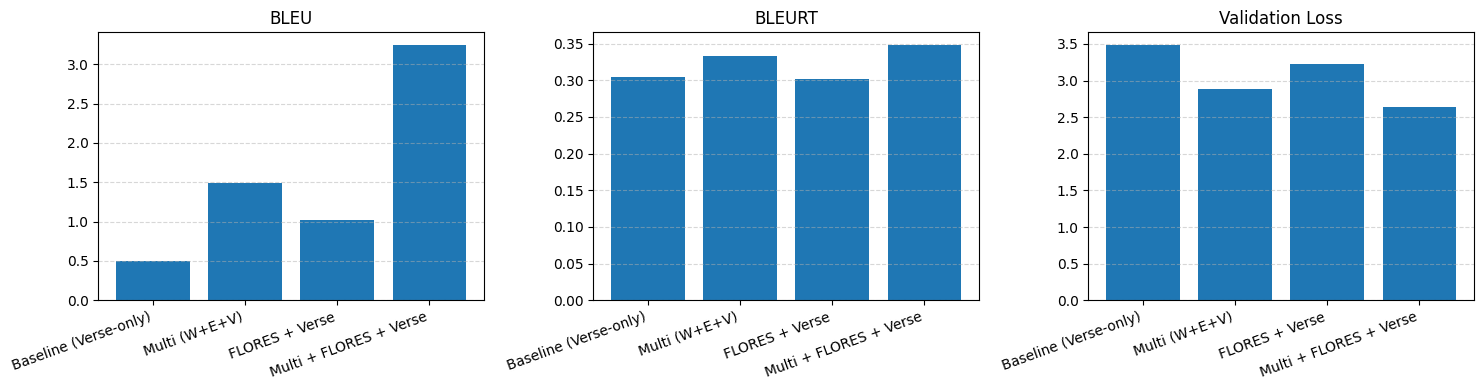

In [18]:
# ------------------------------------------------------------
# 6.3 Charts and Visualizations for Comparison
# ------------------------------------------------------------

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

metrics = ["BLEU", "BLEURT", "Loss"]
titles  = ["BLEU", "BLEURT", "Validation Loss"]

for ax, metric, title in zip(axes, metrics, titles):
    ax.bar(results_table["Model"], results_table[metric])
    ax.set_title(title)
    ax.set_xticklabels(results_table["Model"], rotation=20, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


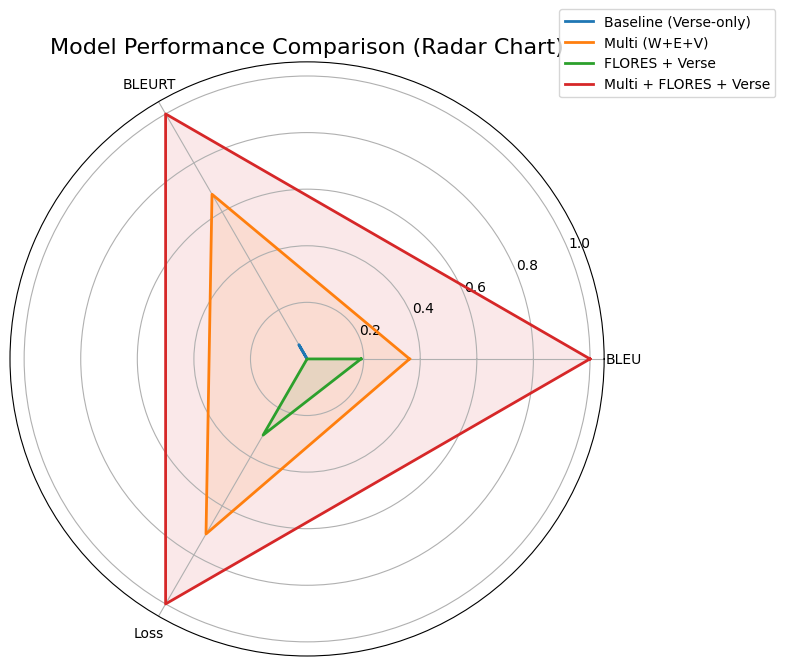

In [19]:
# ------------------------------------------------------------
# 6.4 Charts Continued
# ------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt


metrics = ["BLEU", "BLEURT", "Loss"]

# Normalize metrics to 0–1 range for spider chart
norm_df = results_table.copy()
for m in metrics:
    # For Loss, invert because lower = better
    if m == "Loss":
        norm_df[m] = 1 - (norm_df[m] - norm_df[m].min()) / (norm_df[m].max() - norm_df[m].min())
    else:
        norm_df[m] = (norm_df[m] - norm_df[m].min()) / (norm_df[m].max() - norm_df[m].min())

# Setup angular coordinates
N = len(metrics)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close loop

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot each model
for _, row in norm_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # close loop
    ax.plot(angles, values, linewidth=2, label=row["Model"])
    ax.fill(angles, values, alpha=0.1)


ax.set_thetagrids(np.degrees(angles[:-1]), metrics)

plt.title("Model Performance Comparison (Radar Chart)", size=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


The metrics for each of the four models is shown in the table above, showing the FLORES+Multi model as the clear outperformer in the cohort.

*   Loss: The Multi + FLORES + Verse model converges best (2.643), strongly outperforming all other models.
*   BLEU Score: BLEU jumps from 0.495 (baseline) → 3.245 (best model)—a 6× improvement.
*   BLEURT Score: Semantic quality improves from 0.304 → 0.348, confirming better "human" meaning.
*   Accuracy: Only the best model achieves non-zero accuracy (0.023), reflecting improved exact-match consistency. Note, we expect 0 Accuracy until the model was able to accurately match reference translation 1 to 1.

Overall, the FLORES+ Multi-stage (FLORES+Word+Expression+Verse) approach consistently performed the best across loss, BLEU, and BLEURT metrics, demonstrating the benefit of pre-training on more granular, in-domain data.


### Qualitative Analysis
Examing the translation samples above shows the following trends:

*   **Baseline:** Often produces very generic or repetitive phrases, indicating a lack of understanding of the specific Arabic context.
*   **Multi-stage:** Shows an improved ability to pick up on specific keywords and sometimes captures partial meaning, though still struggles with accurate sentence construction and nuanced translation. The translations tend to be more coherent than the baseline.
*   **FLORES+Verse:** While sometimes capturing keywords, the FLORES-pretrained model often introduces phrases or concepts that are not present in the original Quranic verse, likely due to its pre-training on Modern Standard Arabic (MSA) which might have different stylistic and thematic patterns than Quranic Arabic.
*   **FLORES+Multi:** This model shows the strongest thematic alignment while preserving the semantic field  but still hallucinates content. Still this achieves closest approximation to the tone and narrative themes.

### Conclusion and Future Work

The multi-stage training approach—using word- and expression-level pre-training before verse fine-tuning—clearly improved translation quality. It outperformed the verse-only baseline across BLEU, BLEURT, and loss, and produced more thematically accurate translations. This shows that granular, domain-specific supervision helps the model build stronger representations of Quranic Arabic.

Pre-training on FLORES+ alone did not match this improvement and often introduced MSA-style hallucinations due to domain mismatch. However, when FLORES pretraining was applied after the multi-stage steps, the combined Multi + FLORES + Verse model achieved the best overall performance. This indicates that FLORES adds value only once the model has already learned the core structures of Quranic Arabic.

**Future Work:**
1.  **More In-domain Data:** Explore larger datasets for word and expression level pre-training specific to Quranic Arabic if available.
2.  **Fine-tuning Hyperparameters:** Conduct a more extensive hyperparameter search for each training stage to potentially further optimize performance.
3.  **Advanced Model Architectures:** Experiment with larger mT5 models (e.g., mt5-base, mt5-large) or other state-of-the-art sequence-to-sequence models.
4.  **Error Analysis:** Perform a detailed error analysis to identify common types of translation errors and target them with specific data augmentation or model improvements.
5.  **Human Evaluation:** Incorporate human evaluation to get a more reliable assessment of translation quality, as automated metrics can sometimes be misleading.
